In [1]:
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("dark_background")

In [3]:
from dask.distributed import Client, LocalCluster
import dask.bag as db

In [4]:
dask_cluster = LocalCluster(n_workers=10, threads_per_worker=1, memory_limit='2GB')
dask_client = Client(dask_cluster)

In [5]:
dask_client

Client Scheduler: tcp://127.0.0.1:51620 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 10 Cores: 10 Memory: 20.00 GB


# No evaluation

In [ ]:
from tibert.data import CorpusSplitType, KangyurLoader, TengyurLoader

In [ ]:
import dask_ml

In [ ]:
kangyur_df = KangyurLoader("../../tibert_data/").dataframe
tengyur_df = TengyurLoader("../../tibert_data/").dataframe
kangyur_df['work'], tengyur_df['work'] = 'Kangyur', 'Tengyur'

In [ ]:
sections_df = kangyur_df.append(tengyur_df)

In [ ]:
sections_df = sections_df[~(sections_df.text == '')]

In [ ]:
train_df = sections_df

### Save the raw dataframes

In [ ]:
import os

In [ ]:
save_dir = "c:/workspace/tibert_data/training/tibetan_sections/"

In [ ]:
train_df \
    .repartition(npartitions=20) \
    .to_parquet(os.path.join(save_dir, "only_train"))

# Raw text dump of Tibetan sections

In [6]:
from tibert.data import CorpusSplitType, KangyurLoader, TengyurLoader

In [7]:
import dask_ml

In [8]:
kangyur_df = KangyurLoader("../../tibert_data/").dataframe
tengyur_df = TengyurLoader("../../tibert_data/").dataframe
kangyur_df['work'], tengyur_df['work'] = 'Kangyur', 'Tengyur'

In [9]:
sections_df = kangyur_df.append(tengyur_df)

In [ ]:
sections_df.count().compute()

In [10]:
sections_df = sections_df[~(sections_df.text == '')]

In [11]:
train_df = sections_df

In [ ]:
sections_df.count().compute()

In [ ]:
train_df, test_df = dask_ml.model_selection.train_test_split(
    sections_df,
    test_size=0.01,
    random_state=42,
    shuffle=False)

In [ ]:
train_df.count().compute(), test_df.count().compute()

### Save the raw dataframes

In [ ]:
import os

In [ ]:
save_dir = "c:/workspace/tibert_data/training/tibetan_sections/"

In [ ]:
train_df \
    .repartition(npartitions=20) \
    .to_parquet(os.path.join(save_dir, "train"))

In [ ]:
test_df \
    .repartition(npartitions=5) \
    .to_parquet(os.path.join(save_dir, "test"))

## As a BERT-format list of document sections

## Split into individual sections

In [12]:
train_df["split_text"] = train_df \
    .text \
    .str.split(' ') \
    .map(
        lambda ts: ts + [''],
        meta=pd.Series([['a', 'b']]))

# test_df["split_text"] = test_df \
#     .text \
#     .str.split(' ') \
#     .map(
#         lambda ts: ts + [''],
#         meta=pd.Series([['a', 'b']]))

### Save a BERT-like dataset

In [13]:
train_df = train_df.explode("split_text").reset_index(drop=True)
train_df["split_text"] = train_df.split_text.str.strip()

# test_df = test_df.explode("split_text").reset_index(drop=True)
# test_df["split_text"] = test_df.split_text.str.strip()

In [ ]:
train_df.count().compute()#, test_df.count().compute()

In [ ]:
train_df.volume_number.unique().count().compute()#, test_df.volume_number.unique().count().compute()

#### Sanity check

In [ ]:
sections_df["split_text"] = sections_df \
    .text \
    .str.split(' ') \
    .map(
        lambda ts: ts + [''],
        meta=pd.Series([['a', 'b']]))

In [ ]:
sections_df = sections_df.explode("split_text").reset_index(drop=True)
sections_df["split_text"] = sections_df.split_text.str.strip()

In [ ]:
vn_cts_df = sections_df.groupby(['work', 'volume_number']).split_text.count().compute()

In [ ]:
vn_cts_df[vn_cts_df.index.get_level_values('work') == 'Kangyur'].plot(kind='bar', figsize=(20, 10))

In [ ]:
vn_cts_df[vn_cts_df.index.get_level_values('work') == 'Tengyur'].plot(kind='bar')

### Group and save

In [14]:
train_df["save_group"] = train_df.volume_number.map(lambda vn: vn % 20)
# test_df["save_group"] = "test_data"

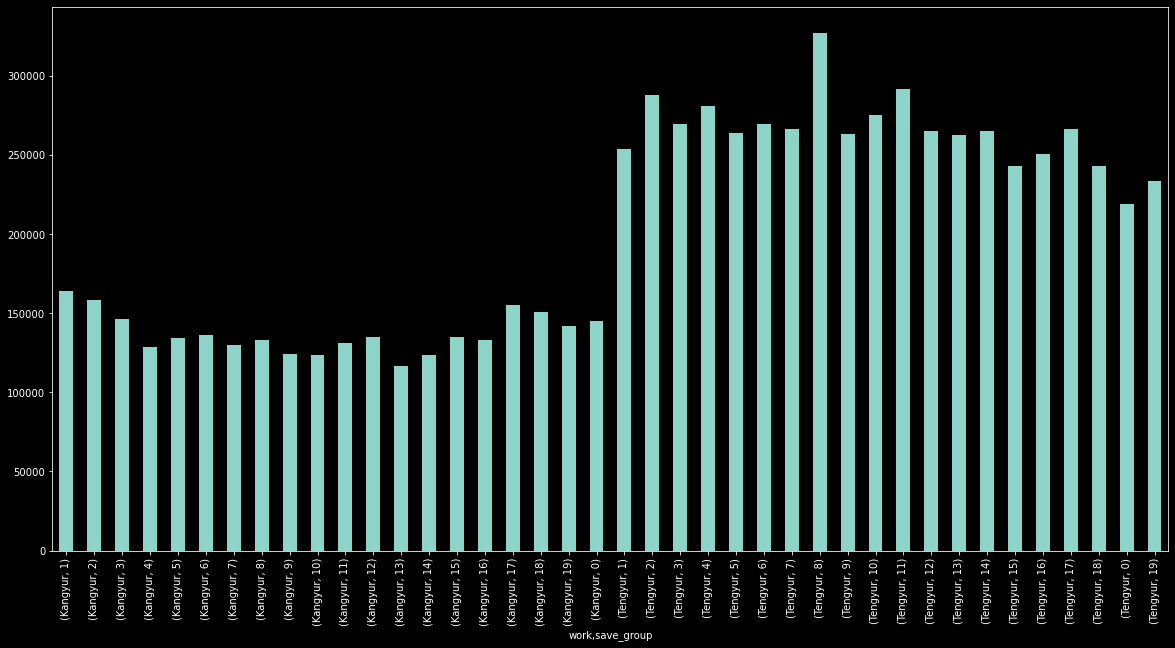

In [15]:
train_df.groupby(['work', 'save_group']).count().compute().split_text.plot(kind='bar', figsize=(20, 10))

In [16]:
train_df['save_group'] = 'train_' + train_df.work + train_df.save_group.astype(str)

In [17]:
# train_df, test_df = train_df.set_index('save_group'), test_df.set_index('save_group')
train_df = train_df.set_index('save_group')

In [35]:
divisions = sorted(['train_Kangyur' + str(i) for i in range(20)] + ['train_Tengyur' + str(i) for i in range(20)])
divisions = divisions + [divisions[-1]]
# divisions, sorted(divisions)
# See here: https://stackoverflow.com/questions/54307559/repartition-dask-dataframe-with-custom-index

In [ ]:
train_df.index.unique().compute()

In [37]:
train_df = train_df.repartition(divisions=divisions)
# test_df = test_df.repartition(npartitions=1)

In [38]:
train_df.divisions

('train_Kangyur0',
 'train_Kangyur1',
 'train_Kangyur10',
 'train_Kangyur11',
 'train_Kangyur12',
 'train_Kangyur13',
 'train_Kangyur14',
 'train_Kangyur15',
 'train_Kangyur16',
 'train_Kangyur17',
 'train_Kangyur18',
 'train_Kangyur19',
 'train_Kangyur2',
 'train_Kangyur3',
 'train_Kangyur4',
 'train_Kangyur5',
 'train_Kangyur6',
 'train_Kangyur7',
 'train_Kangyur8',
 'train_Kangyur9',
 'train_Tengyur0',
 'train_Tengyur1',
 'train_Tengyur10',
 'train_Tengyur11',
 'train_Tengyur12',
 'train_Tengyur13',
 'train_Tengyur14',
 'train_Tengyur15',
 'train_Tengyur16',
 'train_Tengyur17',
 'train_Tengyur18',
 'train_Tengyur19',
 'train_Tengyur2',
 'train_Tengyur3',
 'train_Tengyur4',
 'train_Tengyur5',
 'train_Tengyur6',
 'train_Tengyur7',
 'train_Tengyur8',
 'train_Tengyur9',
 'train_Tengyur9')

In [39]:
train_df.npartitions#, test_df.npartitions

40

In [23]:
def test_f(df):
    return df.index[0]

In [24]:
tdf = train_df.split_text.map_partitions(test_f, meta=pd.Series(["HI"])).compute()
tdf

0      train_Kangyur0
1      train_Kangyur1
2     train_Kangyur10
3     train_Kangyur11
4     train_Kangyur12
5     train_Kangyur13
6     train_Kangyur14
7     train_Kangyur15
8     train_Kangyur16
9     train_Kangyur17
10    train_Kangyur18
11    train_Kangyur19
12     train_Kangyur2
13     train_Kangyur3
14     train_Kangyur4
15     train_Kangyur5
16     train_Kangyur6
17     train_Kangyur7
18     train_Kangyur8
19     train_Kangyur9
20     train_Tengyur0
21     train_Tengyur1
22    train_Tengyur10
23    train_Tengyur11
24    train_Tengyur12
25    train_Tengyur13
26    train_Tengyur14
27    train_Tengyur15
28    train_Tengyur16
29    train_Tengyur17
30    train_Tengyur18
31    train_Tengyur19
32     train_Tengyur2
33     train_Tengyur3
34     train_Tengyur4
35     train_Tengyur5
36     train_Tengyur6
37     train_Tengyur7
38     train_Tengyur8
dtype: object

In [40]:
save_dir = "c:/workspace/tibert_data/training/tibetan_sections/bert-like"

In [41]:
def save_partition_to_disk(partition, save_dir):
    import os
    part_name = partition.index[0]
    with open(os.path.join(save_dir, part_name + ".txt"), mode='w', encoding='utf-8') as f:
        for row in partition.iteritems():
            f.write(row[1] + '\n')

In [42]:
_ = train_df.split_text.map_partitions(save_partition_to_disk, save_dir, meta=pd.Series([None])).compute()

In [ ]:
_ = test_df.split_text.map_partitions(save_partition_to_disk, save_dir, meta=pd.Series([None])).compute()

## As a bag

### Tokenizer training data

In [ ]:
tibetan_sections = db \
    .concat([
        KangyurLoader("../../tibert_data/").to_bag(split_type=CorpusSplitType.BY_SECTION),
        TengyurLoader("../../tibert_data/").to_bag(split_type=CorpusSplitType.BY_SECTION)]) \
    .str.strip()

In [ ]:
tibetan_sections \
    .random_sample(0.1) \
    .repartition(5) \
    .to_textfiles("../../tibert_data/training/tibetan_sections_bag/spm_train.*.txt")

### Raw sections

In [ ]:
tibetan_sections = tibetan_sections \
    .to_dataframe(columns=["section"]) \
    .section

In [ ]:
train_sections, test_sections = [s.to_bag() for s in dask_ml.model_selection.train_test_split(
    tibetan_sections,
    test_size=0.1,
    random_state=42,
    shuffle=True)]

In [ ]:
train_sections.count().compute(), test_sections.count().compute()

In [ ]:
train_sections.take(20)

In [ ]:
train_sections.repartition(20).to_textfiles("../../tibert_data/training/tibetan_sections_bag/train.*.txt")

In [ ]:
test_sections.repartition(5).to_textfiles("../../tibert_data/training/tibetan_sections_bag/test.*.txt")

# Tokenizer training

# Packaged training script

In [ ]:
from tibert.models import TibertTokenizer

In [ ]:
TibertTokenizer.train(
    "../../tibert_data/training/tibetan_sections/spm_train.*.txt",
    '../../tibert_data/training/models/tokenizer/tibert_spm_bpe_tiny',
    model_type='bpe',
    vocab_size=5000)

In [ ]:
TibertTokenizer.train(
    "../../tibert_data/training/tibetan_sections/spm_train.*.txt",
    '../../tibert_data/training/models/tokenizer/tibert_spm_bpe_small',
    model_type='bpe',
    vocab_size=10000)

In [ ]:
TibertTokenizer.train(
    "../../tibert_data/training/tibetan_sections/spm_train.*.txt",
    '../../tibert_data/training/models/tokenizer/tibert_spm_bpe_big',
    model_type='bpe',
    vocab_size=30000)

## Testing

In [ ]:
import sentencepiece as spm

In [ ]:
spm_encoder = spm.SentencePieceProcessor(model_file='../../tibert_data/training/models/tokenizer/tibert_spm_bpe_big.model')

In [ ]:
test_str = "།ཁྱིམ་དོན་ཆེ་ཆུང་སྤངས་ཏེ་དང་པོར་རབ་འབྱུང་དཀའ།"

In [ ]:
spm_encoder.decode(spm_encoder.encode(test_str))

In [ ]:
spm_encoder.decode(spm_encoder.encode(test_str)) == test_str

In [ ]:
spm_encoder.decode(spm_encoder.sample_encode_as_ids(test_str, nbest_size=64, alpha=0.1)) == test_str

In [ ]:
from tibert.models import TibertTokenizer

In [ ]:
tokenizer = TibertTokenizer.from_pretrained("tibert-bpe-large")

In [ ]:
tokenizer.decode(tokenizer.encode(test_str)), tokenizer.decode(tokenizer.encode(test_str, add_special_tokens=False)) == test_str

In [ ]:
tokenizer.keep_accents = False

In [ ]:
tokenizer.decode(tokenizer.encode(test_str))

In [ ]:
tokenizer.keep_accents = True

In [ ]:
test_str, tokenizer.preprocess_text(test_str), test_str == tokenizer.preprocess_text(test_str)

In [ ]:
tokenizer.decode(tokenizer.encode(test_str)), tokenizer.decode(tokenizer.encode(test_str, add_special_tokens=False)) == test_str

# Huggingface Transformer and Tokenizer training experiments

In [ ]:
import glob

paths = glob.glob("../../tibert_data/training/tibetan_sections/spm_train.*.txt")

## Example from Huggingface

In [ ]:
from tokenizers import ByteLevelBPETokenizer

tokenizer = ByteLevelBPETokenizer()
tokenizer.train(
    files=paths,
    vocab_size=52_000,
    min_frequency=2,
    special_tokens=[
        "<s>",
        "<pad>",
        "</s>",
        "<unk>",
        "<mask>"])

In [ ]:
tokenizer.save_model("../../tibert_data/training/models/test-model/", name="tibert")

## SentencePiece

In [ ]:
from transformers import AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")

In [ ]:
tokenizer.sp_model.EncodeAsPieces("We are showing you a test of the SentencePiece tokenizer for Albert. Transformers are cool.")

In [ ]:
import sentencepiece as spm

In [ ]:
','.join(set(["[CLS]", "[SEP]", "<unk>", "[SEP]", "<pad>", "[CLS]", "[MASK]"]))

In [ ]:
spm.SentencePieceTrainer.train(
    input=paths,
    model_prefix='../../tibert_data/training/models/test-model/tibert_spm_bpe',
    model_type='bpe',
    character_coverage=1.0,
    vocab_size=10000,
    user_defined_symbols="<foo>, <bar>")

In [ ]:
spm.SentencePieceTrainer.train(
    input=paths,
    model_prefix='../../tibert_data/training/models/test-model/tibert_spm_bpe',
    model_type='bpe',
    character_coverage=1.0,
    vocab_size=10000,
    user_defined_symbols="[CLS], [SEP], [MASK], <pad>")

In [ ]:
spm_encoder = spm.SentencePieceProcessor(model_file='../../tibert_data/training/models/test-model/tibert_spm_bpe.model')

In [ ]:
spm_encoder.EncodeAsPieces("དེ་དག་གལ་ཏེ་དགེ་སློང་གིས་མཐོང་ནས་མངོན་པར་མི་དགའ་བ་དང་།")

# Load the trained tokenizer and prepare it for model feeding

In [ ]:
from transformers import AutoTokenizer
from tibert.models import TibertTokenizer

In [ ]:
albert_tkn = AutoTokenizer.from_pretrained("albert-base-v2")

In [ ]:
tibert_tkn = TibertTokenizer(TibertTokenizer.pretrained_vocab_files_map['vocab_file']['tibert-bpe-small'])

In [ ]:
albert_tkn("Hi there everybody!")

In [ ]:
tibert_tkn("དེ་དག་གལ་ཏེ་དགེ་སློང་གིས་མཐོང་ནས་མངོན་པར་མི་དགའ་བ་དང་།", "ང་གིས་མཐོང་ནས་མངོན་པར་མི་དགའ་བ་དང་།")

In [ ]:
' '.join(str(id_) for id_ in tibert_tkn("དེ་དག་གལ་ཏེ་དགེ་སློང་གིས་མཐོང་ནས་མངོན་པར་མི་དགའ་བ་དང་།").input_ids)

In [ ]:
tibert_tkn.build_inputs_with_special_tokens(tibert_tkn("དེ་དག་གལ་ཏེ་དགེ་སློང་གིས་མཐོང་ནས་མངོན་པར་མི་དགའ་བ་དང་།").input_ids)

In [ ]:
' '.join(str(id_) for id_ in albert_tkn("Hello there everybody!").input_ids)

In [ ]:
albert_tkn.build_inputs_with_special_tokens(albert_tkn("Hello there everybody!").input_ids)

In [ ]:
albert_tkn.sep_token_id, tibert_tkn.sep_token_id

In [ ]:
tibert_tkn.stochastic_tokenization = True
for _ in range(5):
    print(tibert_tkn("དེ་དག་གལ་ཏེ་དགེ་སློང་གིས་མཐོང་ནས་མངོན་པར་མི་དགའ་བ་དང་།").input_ids)

In [ ]:
tibert_tkn.stochastic_tokenization = False
for _ in range(5):
    print(tibert_tkn("དེ་དག་གལ་ཏེ་དགེ་སློང་གིས་མཐོང་ནས་མངོན་པར་མི་དགའ་བ་དང་།").input_ids)

In [ ]:
albert_tkn.pad_token, albert_tkn.pad_token_id, albert_tkn.pad_token_type_id, albert_tkn.padding_side

In [ ]:
tibert_tkn.pad_token, tibert_tkn.pad_token_id, tibert_tkn.pad_token_type_id, tibert_tkn.padding_side

## Test Dask bag transform

In [ ]:
file_glob = "../../tibert_data/training/tibetan_sections/train.*.txt"

In [ ]:
from transformers import AutoTokenizer
from tibert.models import TibertTokenizer

In [ ]:
albert_tkn = AutoTokenizer.from_pretrained("albert-base-v2")

In [ ]:
tibert_tkn = TibertTokenizer(TibertTokenizer.pretrained_vocab_files_map['vocab_file']['tibert-bpe-small'])

In [ ]:
tokenizer = tibert_tkn
block_size = 512

In [ ]:
token_bag = db \
    .read_text(file_glob) \
    .filter(lambda line: len(line) > 0 and not line.isspace()) \
    .repartition(100) \
    .map(lambda line: tokenizer(line, add_special_tokens=True, truncation=True, max_length=block_size)['input_ids'])

In [ ]:
all_tokens = token_bag.compute()

In [ ]:
from transformers import LineByLineTextDataset

dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path="../../tibert_data/training/tibetan_sections/train.00.txt",
    block_size=128)

In [ ]:
len(dataset)

In [ ]:
dataset[3]

In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

In [ ]:
data_collator([dataset[0], dataset[1], dataset[2], dataset[3]])